In [1]:
pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip available: 22.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install accelerate -U


[notice] A new release of pip available: 22.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

# from transformers import TrainingArguments, Trainer

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Grab a GPU if there is one
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


In [4]:
from sklearn.preprocessing import StandardScaler
import numpy as np

fold_pamap = "../down_stream_dataset/adl_dataset/"
train_xyz = np.load(f"{fold_pamap}x_train.npy")
valid_xyz = np.load(f"{fold_pamap}x_valid.npy")
test_xyz = np.load(f"{fold_pamap}x_test.npy")
train_label = np.load(f"{fold_pamap}y_train.npy")
valid_label = np.load(f"{fold_pamap}y_valid.npy")
test_label = np.load(f"{fold_pamap}y_test.npy")

# データの形を確認
print(f"Train data shape: {train_xyz.shape}, Train label shape: {train_label.shape}")
print(f"Valid data shape: {valid_xyz.shape}, Valid label shape: {valid_label.shape}")
print(f"Test data shape: {test_xyz.shape}, Test label shape: {test_label.shape}")

# 各データセットを個別に標準化
scaler_train = StandardScaler()
scaler_valid = StandardScaler()
scaler_test = StandardScaler()

# train_xyz の標準化
train_xyz_reshaped = train_xyz.reshape(-1, train_xyz.shape[-1])  # 2Dに変換
scaled_train_xyz = scaler_train.fit_transform(train_xyz_reshaped)  # 標準化
scaled_train_xyz = scaled_train_xyz.reshape(train_xyz.shape)  # 元の形に戻す

# valid_xyz の標準化
valid_xyz_reshaped = valid_xyz.reshape(-1, valid_xyz.shape[-1])  # 2Dに変換
scaled_valid_xyz = scaler_valid.fit_transform(valid_xyz_reshaped)  # 標準化
scaled_valid_xyz = scaled_valid_xyz.reshape(valid_xyz.shape)  # 元の形に戻す

# test_xyz の標準化
test_xyz_reshaped = test_xyz.reshape(-1, test_xyz.shape[-1])  # 2Dに変換
scaled_test_xyz = scaler_test.fit_transform(test_xyz_reshaped)  # 標準化
scaled_test_xyz = scaled_test_xyz.reshape(test_xyz.shape)  # 元の形に戻す

# 各データセットの形状を再確認
print(f"Scaled Train data shape: {scaled_train_xyz.shape}")
print(f"Scaled Valid data shape: {scaled_valid_xyz.shape}")
print(f"Scaled Test data shape: {scaled_test_xyz.shape}")


Train data shape: (406, 3, 300), Train label shape: (406,)
Valid data shape: (102, 3, 300), Valid label shape: (102,)
Test data shape: (127, 3, 300), Test label shape: (127,)
Scaled Train data shape: (406, 3, 300)
Scaled Valid data shape: (102, 3, 300)
Scaled Test data shape: (127, 3, 300)


In [5]:
print(pd.Series(train_label).value_counts())
print(pd.Series(test_label).value_counts())
print(pd.Series(valid_label).value_counts())


4    186
1     62
2     58
3     54
0     46
dtype: int64
4    51
1    25
3    22
2    19
0    10
dtype: int64
4    42
1    18
3    17
2    15
0    10
dtype: int64


In [6]:
train_xyz = scaled_train_xyz
valid_xyz = scaled_valid_xyz
test_xyz = scaled_test_xyz

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class ClassificationDataset(Dataset):
    def __init__(self, data, labels):
        super().__init__()
        self._data = data 
        self._labels = labels  

    def __len__(self):
        return len(self._labels)

    def __getitem__(self, idx):
        return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


In [8]:
train_label = torch.tensor(train_label, dtype=torch.long)
test_label = torch.tensor(test_label, dtype=torch.long)
valid_label = torch.tensor(valid_label, dtype=torch.long)

train_label = train_label - train_label.min()
test_label = test_label - test_label.min()
valid_label = valid_label - valid_label.min()


In [9]:
train_dataset = ClassificationDataset(train_xyz, train_label)
test_dataset = ClassificationDataset(test_xyz, test_label)
valid_dataset = ClassificationDataset(valid_xyz, valid_label)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [10]:
num_classes = len(np.unique(train_label))
pretrained_model = 'path/roberta_300.pth'

In [11]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from Roberta import RoBertaModelCustom2
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from transformers import RobertaConfig, TrainingArguments, Trainer
from torch.cuda.amp import autocast, GradScaler

best_model_path = 'path/roberta_300.pth'

# モデル構造を再定義
config = RobertaConfig()
model = RoBertaModelCustom2(config, num_sensor_dims=300)

# 重みのロード
model.load_state_dict(torch.load(best_model_path, map_location="cpu"))
model.to(device)

RoBertaModelCustom2(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Linear(in_features=300, out_features=768, bias=True)
      (position_embeddings): Embedding(512, 768, padding_idx=1)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [12]:
# model.to(device)

In [13]:
class FineTunedModel(nn.Module):
    def __init__(self, backbone, num_classes):
        super(FineTunedModel, self).__init__()
        self.backbone = backbone  # 事前学習済みモデル
        self.new_head = nn.Linear(300, num_classes)  # 分類用の新しい出力層

    def forward(self, x):
        x = self.backbone(x)  # (batch_size, seq_len, 3)
        x = x.mean(dim=1)  # 時系列方向で平均化 (seq_len方向)
        x = self.new_head(x)  # 分類用出力
        return x

# モデルを修正
fine_tuned_model = FineTunedModel(model, num_classes=num_classes)
fine_tuned_model.to(device)


FineTunedModel(
  (backbone): RoBertaModelCustom2(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Linear(in_features=300, out_features=768, bias=True)
        (position_embeddings): Embedding(512, 768, padding_idx=1)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): L

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fine_tuned_model.parameters(), lr=1e-4, weight_decay=0.01)

num_epochs = 50
fine_tuned_model.train()

train_loss = []
validation_losses = []
best_valid_loss = float('inf')
best_model_path = 'best_model_downstream_adl_robert.pth'

time_epoch = 0

for epoch in range(num_epochs):
    total_loss = 0
    correct = 0
    total = 0
    
    val_correct = 0
    val_total = 0
    total_val_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        # 順伝播
       
        outputs = fine_tuned_model(inputs)
        loss = criterion(outputs, labels)
        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 統計
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss.append(total_loss / len(train_loader))
    fine_tuned_model.eval()  # Set model to evaluation mode
    
    val_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = fine_tuned_model(val_inputs)
            val_loss = criterion(val_outputs, val_targets)
            val_loss += val_loss.item()
            
            # 統計
            _, val_predicted = torch.max(val_outputs, 1)
            val_total += val_targets.size(0)
            val_correct += (val_predicted == val_targets).sum().item()
            
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            torch.save(fine_tuned_model.state_dict(), best_model_path)
            time_epoch = epoch + 1
    validation_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}, valid Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total:.2f}%, Val Accuracy: {100 * val_correct / val_total:.2f}%")
fine_tuned_model.load_state_dict(torch.load(best_model_path))
print("Best model reloaded with valid loss: ", best_valid_loss/ len(val_loader), f"  time: {time_epoch}")
    

/tmp/ipykernel_45868/3962539304.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


Epoch 1/50, Loss: 1.2751, valid Loss: 1.0621811151504517, Accuracy: 47.78%, Val Accuracy: 57.84%
Epoch 2/50, Loss: 0.8518, valid Loss: 0.9127974510192871, Accuracy: 62.81%, Val Accuracy: 60.78%
Epoch 3/50, Loss: 0.6812, valid Loss: 0.6832645535469055, Accuracy: 75.12%, Val Accuracy: 72.55%
Epoch 4/50, Loss: 0.5366, valid Loss: 0.7894772887229919, Accuracy: 81.53%, Val Accuracy: 73.53%
Epoch 5/50, Loss: 0.4874, valid Loss: 0.7972719073295593, Accuracy: 82.27%, Val Accuracy: 76.47%
Epoch 6/50, Loss: 0.4429, valid Loss: 0.7207929491996765, Accuracy: 82.27%, Val Accuracy: 74.51%
Epoch 7/50, Loss: 0.3693, valid Loss: 0.6138863563537598, Accuracy: 86.45%, Val Accuracy: 82.35%
Epoch 8/50, Loss: 0.3056, valid Loss: 0.6594995260238647, Accuracy: 89.16%, Val Accuracy: 80.39%
Epoch 9/50, Loss: 0.2741, valid Loss: 0.6692320108413696, Accuracy: 90.64%, Val Accuracy: 76.47%
Epoch 10/50, Loss: 0.2595, valid Loss: 0.8078792691230774, Accuracy: 89.66%, Val Accuracy: 77.45%
Epoch 11/50, Loss: 0.1907, va

In [15]:
val_loss = []
for i in range(num_epochs):
    value = validation_losses[i].item()
    val_loss.append(value)


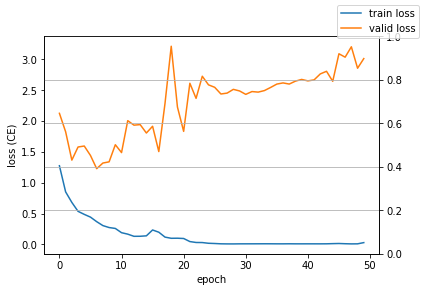

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

plt.close('all')
fig, ax = plt.subplots()
ax.plot(train_loss, color='C0', label='train loss')
ax.plot(val_loss, color='C1', label='valid loss')

ax.set_ylabel('loss (CE)')
ax.set_xlabel('epoch')

# 二軸グラフの追加
ax2 = ax.twinx()
ax2.grid(True)

# 凡例の表示
fig.legend(loc='upper right')

# グラフの表示
plt.show()


Test Accuracy: 85.04%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.86      1.00      0.93        25
           2       0.70      0.74      0.72        19
           3       1.00      0.86      0.93        22
           4       0.84      0.96      0.90        51

    accuracy                           0.85       127
   macro avg       0.88      0.73      0.73       127
weighted avg       0.87      0.85      0.83       127



/tmp/ipykernel_45868/3962539304.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self._data[idx], dtype=torch.float32), torch.tensor(self._labels[idx], dtype=torch.long)


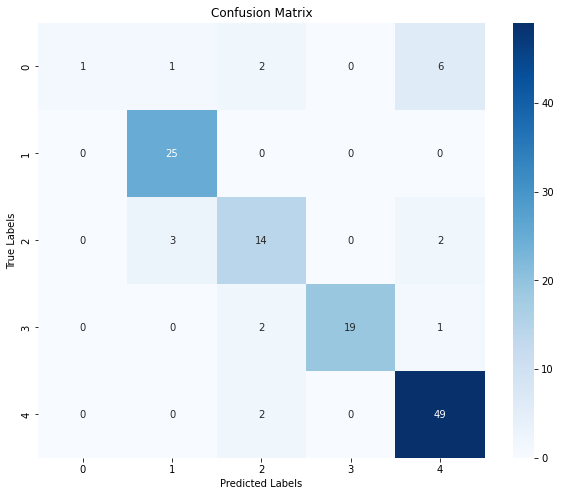

In [18]:
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_model(model, test_loader, device):
    model.eval()
    test_correct = 0
    test_total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
          
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = 100 * test_correct / test_total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, zero_division=0))

    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    return test_accuracy, all_preds, all_labels


test_accuracy, test_preds, test_labels = evaluate_model(fine_tuned_model, test_loader, device)
